## Hyperparameter tuning for Decision Tree

In [23]:
import pandas as pd
import json
import joblib
import os
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report # Added classification_report

# 1. Load Data
df = pd.read_csv('../data/telco_churn_processed.csv')
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Define the "Grid" of settings
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# 3. Setup the Grid Search
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           verbose=1,
                           scoring='accuracy')

# 4. Run the Search
print("Starting Hyperparameter Tuning...")
grid_search.fit(X_train, y_train)

# 5. The Results
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\n✅ Best Parameters Found: {best_params}")
print(f"✅ Best Cross-Validation Accuracy: {best_score:.4f}")

# 6. Evaluate the "Optimized" Model on Test Data
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_tuned)
print(f"Test Set Accuracy of Optimized Tree: {test_acc:.4f}")

# Detailed Report
print("\n--- Classification Report (Tuned Tree) ---")
print(classification_report(y_test, y_pred_tuned))

# SAVE THE TUNED MODEL & SCORE
os.makedirs('../models', exist_ok=True)

joblib.dump(best_model, '../models/dt_tuned.joblib')
print("✅ Tuned Model saved to '../models/dt_tuned.joblib'")

# Save the Score
dt_tuned_data = {'tuned_dt_accuracy': test_acc, 'best_params': best_params}
with open('../models/dt_tuned_score.json', 'w') as f:
    json.dump(dt_tuned_data, f)
print("✅ Tuned Score saved to '../models/dt_tuned_score.json'")

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

✅ Best Parameters Found: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}
✅ Best Cross-Validation Accuracy: 0.7931
Test Set Accuracy of Optimized Tree: 0.7765

--- Classification Report (Tuned Tree) ---
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1053
           1       0.55      0.57      0.56       352

    accuracy                           0.78      1405
   macro avg       0.70      0.71      0.71      1405
weighted avg       0.78      0.78      0.78      1405

✅ Tuned Model saved to '../models/dt_tuned.joblib'
✅ Tuned Score saved to '../models/dt_tuned_score.json'


## Confusion Matrix

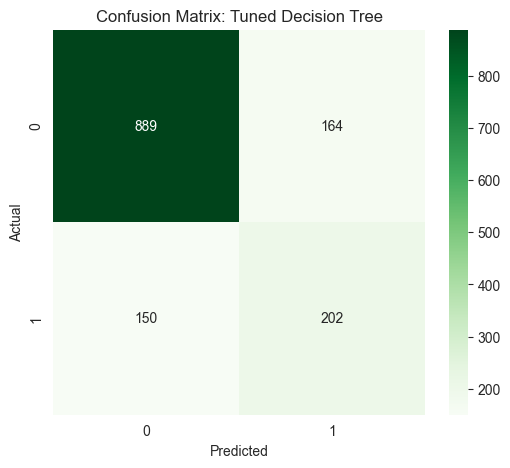

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a heatmap
plt.figure(figsize=(6, 5))
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix: Tuned Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 2. Neural Network Hyperparameter Tuning
Unlike Decision Trees, where `GridSearch` is computationally inexpensive, Neural Networks require a **Manual Architecture Search**. We conduct a controlled experiment to determine if increasing model complexity improves performance.

### **Experimental Setup**
* **Model A (Baseline):** The architecture defined in Notebook 03 (Input $\to$ 16 Neurons $\to$ 8 Neurons $\to$ Output). Optimized with `Adam`.
* **Model B (Experiment):** A deeper, wider architecture (Input $\to$ 64 Neurons $\to$ Dropout 20% $\to$ 32 Neurons $\to$ Output). Optimized with `RMSprop`.

### **Hypothesis**
A larger model with Dropout regularization (Model B) should capture more complex non-linear patterns and generalize better than the simpler Model A.

In [8]:
import tensorflow as tf
import json
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

# 1. Load the Baseline Score
try:
    with open('../models/baseline_score.json', 'r') as f:
        data = json.load(f)
        accuracy_baseline = data['baseline_accuracy']
    print(f"✅ Auto-Loaded Baseline Accuracy: {accuracy_baseline:.4f}")
except FileNotFoundError:
    print("⚠️ Warning: Baseline score file not found. Defaulting to 0.7922")
    accuracy_baseline = 0.7922

# 2. Define Model B
model_b = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 3. Compile with a different optimizer
model_b.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Train Model B
print("Training Neural Network Experiment B...")
history_b = model_b.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

# 5. Evaluate
loss_b, acc_b = model_b.evaluate(X_test, y_test)
print(f"\nModel A (Baseline) Accuracy: {accuracy_baseline:.4f}")
print(f"Model B (Tuned) Accuracy:    {acc_b:.4f}")

# Conclusion Logic
print("-" * 30)
if acc_b > accuracy_baseline:
    print("OBSERVATION: The complex architecture (Model B) improved accuracy.")
    print("RECOMMENDATION: Adopt Model B for deployment.")
else:
    print("OBSERVATION: Increasing complexity (Model B) resulted in similar or lower accuracy.")
    print("CONCLUSION: The simpler Model A is more robust. We recommend proceeding with the Baseline model to reduce computational cost.")
print("-" * 30)

# SAVE THE TUNED MODEL
model_b.save('../models/nn_tuned_model.keras')
print("✅ Tuned Neural Network saved to '../models/nn_tuned_model.keras'")

✅ Auto-Loaded Baseline Accuracy: 0.7922
Training Neural Network Experiment B...
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7943 - loss: 0.4260 

Model A (Baseline) Accuracy: 0.7922
Model B (Tuned) Accuracy:    0.7943
------------------------------
OBSERVATION: The complex architecture (Model B) improved accuracy.
RECOMMENDATION: Adopt Model B for deployment.
------------------------------
✅ Tuned Neural Network saved to '../models/nn_tuned_model.keras'


## Visualizing Model B Learning Curves

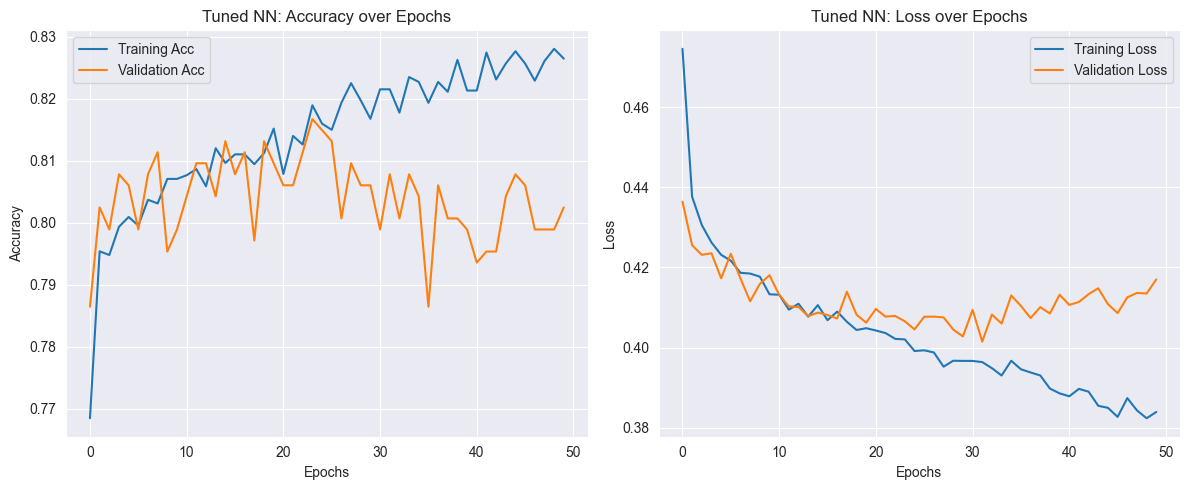

In [20]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Accuracy for Model B
plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_b.history['accuracy'], label='Training Acc')
plt.plot(history_b.history['val_accuracy'], label='Validation Acc')
plt.title('Tuned NN: Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(history_b.history['loss'], label='Training Loss')
plt.plot(history_b.history['val_loss'], label='Validation Loss')
plt.title('Tuned NN: Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. ROC Analysis
We compare the discrimination power of the **Optimized Decision Tree** versus the **Optimized Neural Network**. The Area Under the Curve (AUC) indicates which model is better at ranking churners correctly.

✅ Loaded Tuned Decision Tree for comparison.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


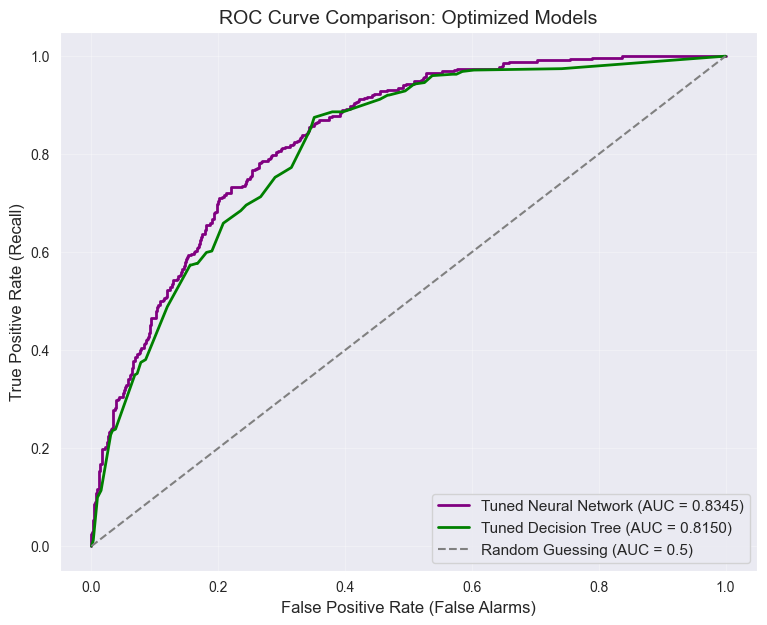

----------------------------------------
CONCLUSION: The Neural Network is superior (AUC +0.0195).
----------------------------------------


In [19]:
from sklearn.metrics import roc_curve, auc
import joblib
import matplotlib.pyplot as plt

# 1. Load the Tuned Decision Tree
try:
    best_tree_model = joblib.load('../models/dt_tuned.joblib')
    print("✅ Loaded Tuned Decision Tree for comparison.")
except FileNotFoundError:
    print("❌ Error: Run the Decision Tree Tuning cell first!")

# 2. Get Probabilities
# Decision Tree: Probability of Class 1
y_pred_dt_prob = best_tree_model.predict_proba(X_test)[:, 1]

# Neural Network: Probability of Class 1
y_pred_nn_prob = model_b.predict(X_test).ravel()

# 3. Calculate ROC Metrics
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt_prob)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn_prob)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# 4. Plot the Comparison
plt.figure(figsize=(9, 7))

# Plot Neural Network
plt.plot(fpr_nn, tpr_nn, label=f'Tuned Neural Network (AUC = {roc_auc_nn:.4f})', color='purple', linewidth=2)

# Plot Decision Tree
plt.plot(fpr_dt, tpr_dt, label=f'Tuned Decision Tree (AUC = {roc_auc_dt:.4f})', color='green', linewidth=2)

# Plot Random Guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing (AUC = 0.5)')

# Labels and Title
plt.title('ROC Curve Comparison: Optimized Models', fontsize=14)
plt.xlabel('False Positive Rate (False Alarms)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.show()

print("-" * 40)
if roc_auc_nn > roc_auc_dt:
    print(f"CONCLUSION: The Neural Network is superior (AUC +{roc_auc_nn - roc_auc_dt:.4f}).")
else:
    print(f"CONCLUSION: The Decision Tree is superior (AUC +{roc_auc_dt - roc_auc_nn:.4f}).")
print("-" * 40)